In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import torchvision.utils as tv_utils

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

In [2]:
class VideoWriter:
    def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1)*255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
        if self.params['filename'] == '_autoplay.mp4':
            self.show()

    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        display(mvp.ipython_display(fn, **kw))

In [8]:
cmap = plt.get_cmap('viridis')
def np2im(a):
    a = cmap(a)
    a = (a * 255).astype(np.uint8)
    return Image.fromarray(a)


def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img

In [3]:
#@title CA Model

class CAModel(torch.nn.Module):
    def __init__(self, chn=16):
        super().__init__()
        # CA Function
        self.chn = chn
        self.wp = torch.nn.Conv2d(chn, 128, 3, stride=1, padding=1)
        self.w1 = torch.nn.Conv2d(128, 128, 1)
        self.w2 = torch.nn.Conv2d(128, chn, 1, bias=False)
#         self.w2.weight.data.zero_()

    def get_living_mask(self, x): # Cell is alive IF any neighbors have alpha>0.1
        colors = x[:, :1, :, :] # Batch, channel, h, w
        pooled = torch.nn.functional.max_pool2d(colors, 3, 1, 1)
        summed = torch.sum(pooled, dim=1)
        return summed > 0.1

    def forward(self, x):
#         pre_life_mask = self.get_living_mask(x)

        y = self.wp(x)
        y = F.relu(y)
        y = self.w1(y)
        y = F.relu(y)
        y = self.w2(y)
        x_new = x + y

#         post_life_mask = self.get_living_mask(x_new)
#         life_mask = pre_life_mask & post_life_mask
#         life_mask = life_mask[:,None,:,:]
#         x_new *= life_mask
        return x_new

    def forward_steps(self, x, steps=1):
        seq = [x]
        for _ in range(steps):
            x = self(x)
            seq.append(x)
        return seq

In [4]:
class CA2Model(nn.Module):
    def __init__(self, chn=16):
        super().__init__()
        self.update = nn.Sequential(
            nn.Conv2d(chn, 16, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, chn, 1, bias=False),
            nn.Sigmoid(),
        )
        self.new = nn.Sequential(
            nn.Conv2d(chn, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, chn, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        y = self.new(x)
        l = self.update(x)
        return x * l + y * (1 - l)

    def forward_steps(self, x, steps=1):
        seq = [x]
        for _ in range(steps):
            x = self(x)
            seq.append(x)
        return seq

In [5]:
channs = 2
ca = CA2Model(channs).train()

In [6]:
inp = torch.randn(1, channs, 64, 64)
out = ca.forward_steps(inp, steps=10)
# out[-1].sum().requires_grad

In [9]:
with VideoWriter(fps=15) as vid, torch.no_grad():
    for frame in out:
        im = frame
        im = cmap(im)
        im = im[:, 0].transpose(0, 3, 1, 2)
        im = torch.tensor(im)[:, :3]
        im = tv_utils.make_grid(im, nrow=4)
        im = im.numpy().transpose(1, 2, 0)
        im = (im * 255).astype(np.uint8)
        im = zoom(im, 5)
        # Image.fromarray(im)
        vid.add(im)

In [10]:
H, W = 32, 32

def get_gate_screen(a, b, c, rand=False):
    screen = np.zeros((H, W))

    size = 20
    pad = 5
    pad_height = ((H - 1) - 3 * pad) // 2

    if a:
        cv2.rectangle(screen, (0, pad), (size, pad + pad_height), 1, -1)

    if b:
        cv2.rectangle(screen, (0, pad + pad_height + pad), (size, (pad + pad_height) * 2), 1, -1)

    if c:
        cv2.rectangle(
            screen,
            (W - size, (H - 1) // 2 - pad_height // 2),
            (W, (H - 1) // 2 + pad_height // 2),
            1, -1
        )

    if rand:
        screen = screen + np.random.randn(*screen.shape) / 5
    return screen

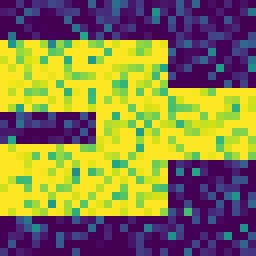

In [11]:
screen = get_gate_screen(1, 1, 1, rand=True)
np2im(zoom(screen, 8))

In [12]:
def sample_one():
    a = [True, False][np.random.randint(0, 2)]
    b = [True, False][np.random.randint(0, 2)]
    c = a ^ b
    inp = get_gate_screen(a, b, 0, rand=True)
    gt = get_gate_screen(a, b, c)
    return inp, gt

def sample_many(size):
    gts = []
    inps = []
  
    for _ in range(size):
        inp, gt = sample_one()
        inps.append(inp)
        gts.append(gt)
  
    inps = torch.tensor(np.stack(inps), dtype=torch.float32).unsqueeze(1)
    gts = torch.tensor(np.stack(gts), dtype=torch.float32).unsqueeze(1)

    return inps, gts

inps, gts = sample_many(16)
gts.shape, inps.shape

(torch.Size([16, 1, 32, 32]), torch.Size([16, 1, 32, 32]))

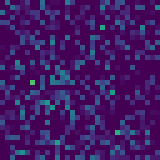

In [13]:
np2im(zoom(inps[1][0].detach().cpu().numpy(), scale=5))

In [14]:
x, y = sample_many(8)

In [15]:
def optim_step(nca, bs, lr):
    ids = np.random.choice(len(gts), size=bs)
    x, y = sample_many(bs)
    opt = optim.Adam(nca.parameters(), lr=lr)

    opt.zero_grad()
    # Requires grad for some reason??
    seed = torch.zeros(bs, channs, H, W)
    seed[:, :1] = x

    out = nca.forward_steps(seed, steps=np.random.randint(20, 30))
    loss = F.mse_loss(out[-1][:, :1], y)
    loss.backward()
    opt.step()

    return loss.item()

In [16]:
channs = 16
nca = CAModel(channs).train()

In [21]:
history = []
pbar = tqdm(range(10000))
for i in pbar:
    loss = optim_step(nca, 8, 0.002)
    pbar.set_description(f'Loss: {loss:.6f}')
    history.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

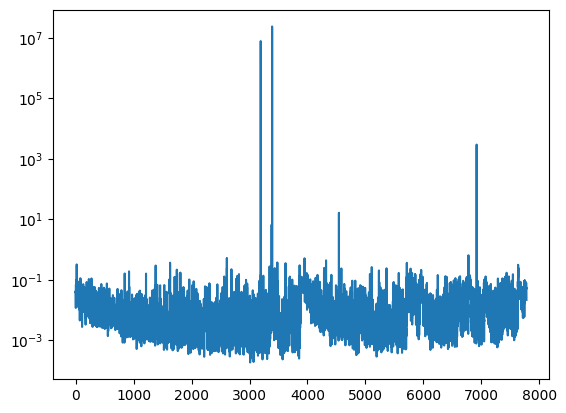

In [22]:
plt.yscale("log")
plt.plot(history)

In [23]:
bs = 8
x, y = sample_many(bs)
seed = torch.zeros(bs, channs, H, W)
seed[:, :1] = x
nca.eval()
with torch.no_grad():
    out = nca.forward_steps(seed, steps=40)

In [24]:
with VideoWriter(fps=5) as vid, torch.no_grad():
    for frame in out:
        im = frame
        im = cmap(im)
        im = im[:, 0].transpose(0, 3, 1, 2)
        im = torch.tensor(im)[:, :3]
        im = tv_utils.make_grid(im, nrow=4)
        im = im.numpy().transpose(1, 2, 0)
        im = (im * 255).astype(np.uint8)
        im = zoom(im, 5)
        # Image.fromarray(im)
        vid.add(im)